# Imports

In [47]:
import sys
sys.path.append('../src')

from data_manager import read_frame, annotations_for_frame, show_annotation
from window_manager import slide_window, draw_boxes
from feature_manager import feature_extraction

import os
import math
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from tqdm import tqdm

import cv2
from skimage import io, color

data_path = '../data'

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [150, 650]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': 2,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}

# Vehicle recognition dataset

In [22]:
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

H, W, C = 720, 1280, 3
N = 2020

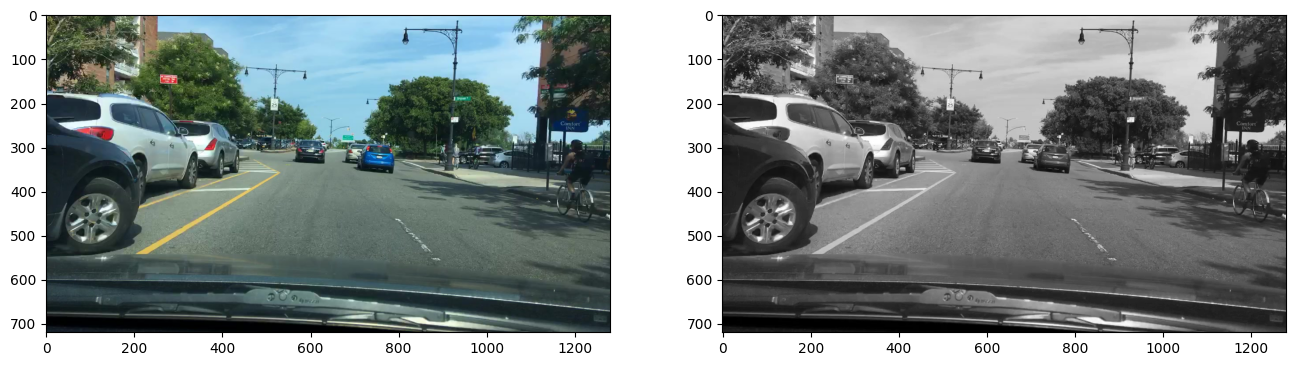

In [23]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
frame = read_frame(data_path, train_df, 0)
gray_frame = (color.rgb2gray(frame)*255).astype(np.uint8)

plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.imshow(frame)

plt.subplot(1, 2, 2)
plt.imshow(gray_frame, cmap='gray')

plt.show()

# Learn interesting window sizes

In [24]:
def round_to_power_of_two(x):
    return 2 ** round(math.log2(x))

interesting_windows = []

for line in tqdm(range(len(train_df))):
    rectangles = annotations_for_frame(train_df, line)
    for _, _, dx, dy in rectangles: 
        interesting_windows.append((round_to_power_of_two(dx), round_to_power_of_two(dy)))

len(interesting_windows)

100%|██████████| 2020/2020 [00:00<00:00, 3758.64it/s]


16018

In [25]:
size_dic = {}

for i in range(1, 11):
    for j in range(1, 11):
        size_dic[(2**i, 2**j)] = interesting_windows.count((2**i, 2**j))

sorted_dic = dict(sorted(size_dic.items(), key=lambda item: item[1], reverse=True))
print(len(sorted_dic))
print(sorted_dic)
print(sum(sorted_dic.values()))

first_values_sum = sum(value for key, value in list(sorted_dic.items())[:5])
print(first_values_sum/len(interesting_windows))

INTERESTING_WINDOWS = list(sorted_dic.keys())[:5]

100
{(32, 32): 2695, (64, 64): 2043, (64, 32): 1763, (128, 64): 1383, (32, 16): 1197, (16, 16): 1045, (128, 128): 1004, (256, 256): 839, (256, 128): 826, (16, 32): 587, (32, 64): 470, (64, 16): 332, (16, 8): 238, (512, 256): 211, (32, 8): 210, (128, 32): 173, (64, 128): 149, (512, 512): 105, (8, 16): 97, (256, 64): 92, (16, 64): 81, (128, 256): 74, (8, 32): 71, (256, 512): 52, (8, 8): 49, (4, 32): 44, (64, 8): 37, (32, 128): 27, (64, 256): 19, (512, 128): 19, (16, 4): 18, (32, 4): 16, (16, 128): 12, (8, 64): 10, (128, 16): 8, (4, 16): 7, (128, 512): 5, (32, 256): 3, (256, 32): 2, (8, 4): 1, (8, 128): 1, (16, 2): 1, (64, 4): 1, (1024, 128): 1, (2, 2): 0, (2, 4): 0, (2, 8): 0, (2, 16): 0, (2, 32): 0, (2, 64): 0, (2, 128): 0, (2, 256): 0, (2, 512): 0, (2, 1024): 0, (4, 2): 0, (4, 4): 0, (4, 8): 0, (4, 64): 0, (4, 128): 0, (4, 256): 0, (4, 512): 0, (4, 1024): 0, (8, 2): 0, (8, 256): 0, (8, 512): 0, (8, 1024): 0, (16, 256): 0, (16, 512): 0, (16, 1024): 0, (32, 2): 0, (32, 512): 0, (32, 1024

# Search window

In [35]:
print(INTERESTING_WINDOWS)
slide_window_params['window_sizes'] = INTERESTING_WINDOWS + [(512, 512)] + [(256, 512)]
slide_window_params['overlapping'] = [0, 0, 0, 0, 0, 0.5, 0.5]

[(32, 32), (64, 64), (64, 32), (128, 64), (32, 16)]


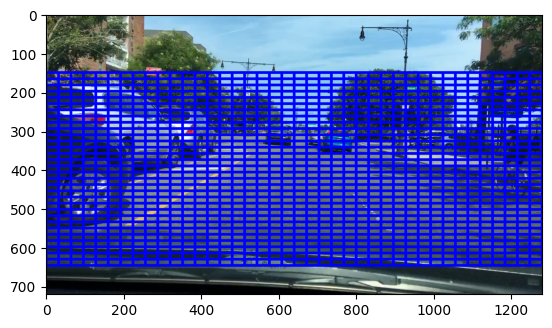

In [36]:
feature_image = frame
windows = slide_window(feature_image, **slide_window_params)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

In [37]:
len(windows)

2350

In [38]:
def search_windows(
    img, windows, 
    scaler, classifier, 
    spatial_size, 
    color_bins_n, color_bins_range, 
    orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis,
    resize=(64,64)
):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    count = 0

    for window in windows:
        count += 1

        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], resize)

        # Extract features for that window using single_img_features()
        features = feature_extraction(
            test_img, 
            spatial_size,
            color_bins_n, color_bins_range,
            orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis
        )

        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        # Predict using your classifier
        prediction = classifier.predict(test_features)

        if prediction == 1 and not any(
            all(
                [win[0][0] <= window[0][0], win[0][1] <= window[0][1],
                 win[1][0] >= window[1][0], win[1][1] >= window[1][1]]
            ) for win in on_windows
        ):
            on_windows.append(window)

    return on_windows

# Recognition

In [39]:
with open('models/subdataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/subdataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

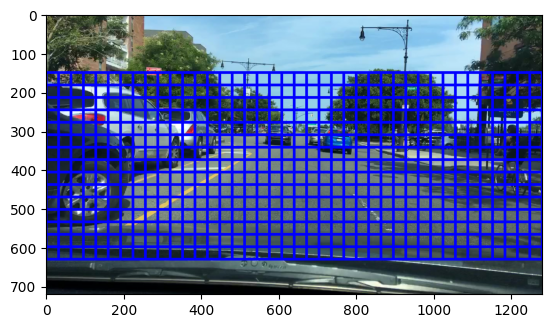

678

In [41]:
# slide_window_params['window_sizes'] = INTERESTING_WINDOWS + [(512, 512)] + [(256, 512)]
# slide_window_params['overlapping'] = [0, 0, 0, 0, 0, 0.5, 0.5]

slide_window_params['window_sizes'] = [(64,64), (128, 128), (256, 256), (512, 512)]
slide_window_params['overlapping'] = [0.5, 0.5, 0.5, 0.5]

feature_image = frame
windows = slide_window(feature_image, **slide_window_params)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

len(windows)

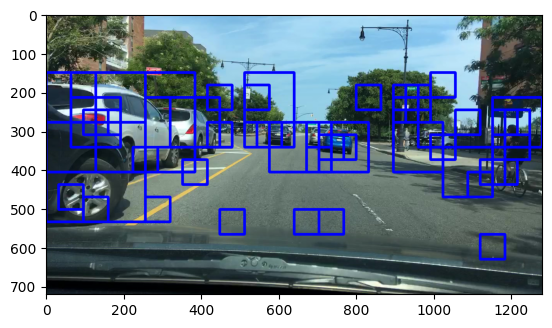

In [43]:
vehicle_windows = search_windows(
    frame, windows,
    scaler, classifier, 
    **spatial_bin_params,
    **color_hist_params,
    **hog_hist_params
)
frame_with_recognition = draw_boxes(frame, vehicle_windows, color=(0, 0, 255), thick=6)  
plt.imshow(frame_with_recognition)
plt.show()

In [50]:
vehicle_windows

[[(64, 150), (128, 214)],
 [(992, 150), (1056, 214)],
 [(416, 182), (480, 246)],
 [(512, 182), (576, 246)],
 [(800, 182), (864, 246)],
 [(896, 182), (960, 246)],
 [(928, 182), (992, 246)],
 [(896, 214), (960, 278)],
 [(928, 214), (992, 278)],
 [(96, 246), (160, 310)],
 [(128, 246), (192, 310)],
 [(1056, 246), (1120, 310)],
 [(1152, 246), (1216, 310)],
 [(1184, 246), (1248, 310)],
 [(416, 278), (480, 342)],
 [(512, 278), (576, 342)],
 [(544, 278), (608, 342)],
 [(576, 278), (640, 342)],
 [(672, 278), (736, 342)],
 [(960, 278), (1024, 342)],
 [(704, 310), (768, 374)],
 [(736, 310), (800, 374)],
 [(992, 310), (1056, 374)],
 [(1184, 310), (1248, 374)],
 [(224, 342), (288, 406)],
 [(672, 342), (736, 406)],
 [(352, 374), (416, 438)],
 [(1120, 374), (1184, 438)],
 [(1152, 374), (1216, 438)],
 [(1088, 406), (1152, 470)],
 [(32, 438), (96, 502)],
 [(96, 470), (160, 534)],
 [(256, 470), (320, 534)],
 [(448, 502), (512, 566)],
 [(640, 502), (704, 566)],
 [(704, 502), (768, 566)],
 [(1120, 566), (

In [51]:
def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])


def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for (x, y), (dx, dy) in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask



slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [150, 650],
    'window_sizes': [(64,64), (128, 128), (256, 256), (512, 512)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': 2,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}
with open('models/subdataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/subdataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)




NAME_OF_OUTPUT_FILE = 'outputs/recognition_with_subdataset.csv'

test_files = sorted(os.listdir(test_data_path), key=lambda x: int(x.split('.')[0]))

rows = [] 
   
for file_name in tqdm(test_files):
    test_image = io.imread(os.path.join(test_data_path, file_name)) 
      
    # Detects cars of different sizes in the input image 
    cars = search_windows(
        frame, windows,
        scaler, classifier, 
        **spatial_bin_params,
        **color_hist_params,
        **hog_hist_params
    ) 
    
    # encode the bounding boxes detected for the frame
    rle = run_length_encoding(bounding_boxes_to_mask(cars, H, W))

    #append the predicted bounding boxes to your results' list
    rows.append(['test/' + file_name, rle])

# generate csv submission
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv(NAME_OF_OUTPUT_FILE)

100%|██████████| 202/202 [12:31<00:00,  3.72s/it]
